In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Exploration

In [32]:
def plotPieChart(x,labels,title,colors = sns.color_palette("pastel"),autopct='%.0f%%',shadow=True, startangle=90, explode=(0.1, 0)):
    plt.title(title.capitalize(),fontsize=16)
    plt.pie(x=x,labels=labels,colors = colors, autopct=autopct,shadow=shadow, startangle=startangle)
    plt.legend()
    plt.show()
    
def plotChartForAllDataset(dataset,excludeList=[]):
    for column_name in set(dataset.columns).difference(excludeList):
        if dataset[column_name].dtype == object or (dataset[column_name].dtype == 'int64' and len(dataset[column_name].unique())<5):
            data=[len(dataset[dataset[column_name] == value]) for value in dataset[column_name].unique()]
            plotPieChart(x=data,title=column_name,labels=dataset[column_name].unique())
        else:
            his = sns.histplot(data=dataset, x=column_name)
            his.set_ylabel("# of Records")
            plt.show()

## Classification

In [27]:
# Importing the datasets
strokeDataset = pd.read_csv('datasets/classification/healthcare-dataset-stroke-data.csv')
waterQualityDataset = pd.read_csv('datasets/classification/waterQuality.csv')
cristalDataset = pd.read_csv('datasets/classification/cristal.csv')
fuelConsumptionDataset = pd.read_csv('datasets/classification/fuelConsumption.csv')
wineQualityDataset = pd.read_csv('datasets/classification/wineQuality.csv')

classificationDatasets = [strokeDataset,waterQualityDataset,cristalDataset,fuelConsumptionDataset,wineQualityDataset]

### Healthcare Stroke dataset

https://nbviewer.org/github/PBPatil/Exploratory_Data_Analysis-Wine_Quality_Dataset/blob/master/winequality_white.ipynb 
https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15

In [ ]:
strokeDataset.info()

In [ ]:
strokeDataset.head()

In [ ]:
strokeDataset.describe()

#### Feature explination


Each record hold an information regarding the patient's health and if he/she had stroke.
For the classification we will discrad the Id attribute bacuse it does not hold any prediction power.

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [ ]:
plotChartForAllDataset(strokeDataset,excludeList=['id'])

### Water Quality dataset 

In [28]:
waterQualityDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [29]:
waterQualityDataset.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [30]:
waterQualityDataset.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


#### Feature explination

1) pH value:
PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards.

2) Hardness:
Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium.

3) Solids (Total dissolved solids - TDS):
Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.

4) Chloramines:
Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.

5) Sulfate:
Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.

6) Conductivity:
Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.

7) Organic_carbon:
Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.

8) Trihalomethanes:
THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. THM levels up to 80 ppm is considered safe in drinking water.

9) Turbidity:
The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.

10) Potability:
Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable.

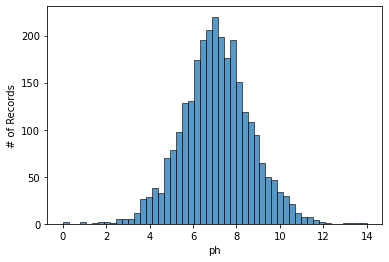

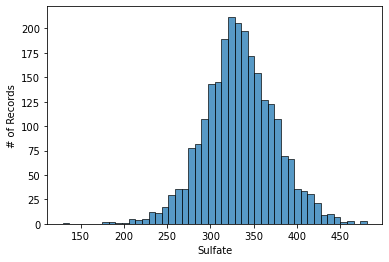

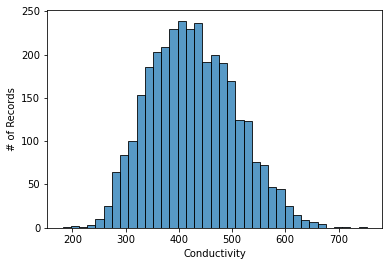

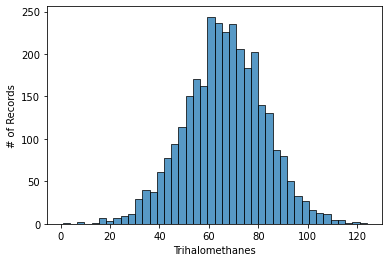

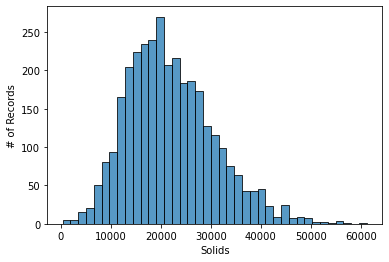

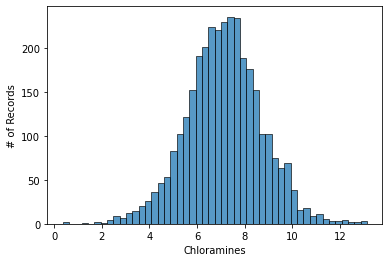

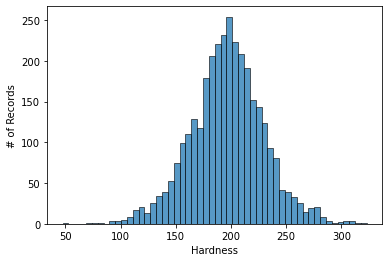

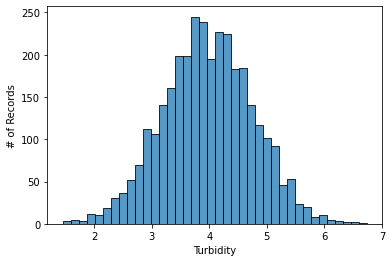

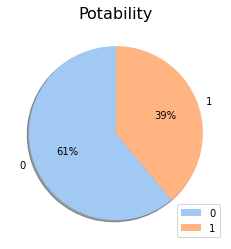

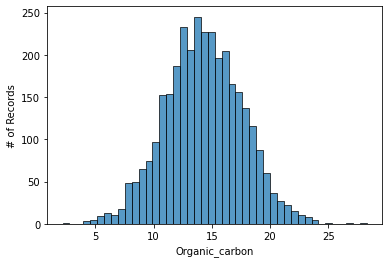

In [33]:
plotChartForAllDataset(waterQualityDataset)

### Cristal dataset 

In [ ]:
cristalDataset.info()

In [ ]:
cristalDataset.head()

In [ ]:
cristalDataset.describe()

#### Feature explination

1) v(A) - Valence of A
2) v(B) - Valence of B
3) Radius A (r(A)) - ionic radius of A cation
4) Radius B (r(B)) - ionic radius of B cation
5) Electronegativity of A (EN(A)) - Average electronegativity value of A cation
6) Electronegativity of B (EN(B)) - Average electronegativity value of B cation
7) l(A-O) - Bond length of A-O pair
8) l(B-O) - Bond length of B-O pair
9) ΔENR - Electronegativity difference with radius
10) tG - Goldschmidt tolerance factor
11) τ New tolerance factor
12) μ - Octahedral factor
13) Lowest distortion - identifies it to be either a cubic, tetragonal, orthorhombic, and rhombohedral structure.

In [ ]:
plotChartForAllDataset(cristalDataset,excludeList=[])

### Fuel Consumption dataset

In [ ]:
fuelConsumptionDataset.info()

In [ ]:
fuelConsumptionDataset.head()

In [ ]:
fuelConsumptionDataset.describe()

#### Feature explination

1) Model Year - The vehicle manufator year
2) Make - The vehicle maker
3) Model - Vehicle Model type: 4WD/4X4 = Four-wheel drive; AWD = All-wheel drive; FFV = Flexible-fuel vehicle; SWB = Short
4) Vehicle Class - The vehicle class type (small, compact, mid-size etc.)
5) Engine Size(L) - The vehicle engine size (2, 3.5 , 2.4 (L) etc.)
6) Cylinders - Number of cylinders    
7) Transmission - Transmission: A = automatic; AM = automated manual; AS = automatic with select shift; AV = continuously
8) Fuel Type - Z = Benzin, X = Soler.
9 - 11) Fuel consumption: City and highway fuel consumption ratings are shown in liters per 100 kilometers - the combined rating (55% city, 45% highway) is shown in L/100 km and in miles per imperial
12) CO2 emissions: the tailpipe emissions of carbon dioxide (in grams per kilometer) for combined city and highway driving
13) CO2 rating: the tailpipe emissions of carbon dioxide rated on a scale from 1 (worst) to 10 (best)
14) Smog rating: the tailpipe emissions of smog-forming pollutants rated on a scale from 1 (worst) to 10 (best)

In [ ]:
plotChartForAllDataset(fuelConsumptionDataset,excludeList=["Model"])

### Wine Quality dataset

In [ ]:
wineQualityDataset.info()

In [ ]:
wineQualityDataset.head()

In [ ]:
wineQualityDataset.describe()

#### Feature explination

1) fixed acidity - Fixed acidity value
2) volatile acidity - Volatile acidity value
3) citric acid - Citric acid value
4) residual sugar - Residual sugar value
5) chlorides - Chlorides value
6) free sulfur dioxide - Free sulfur dioxide value
7) total sulfur dioxide - Total sulfur dioxide value
8) density - Density value
9) pH - pH value
10) sulphates - 
11) alcohol - alcohol rate
12) quality (score between 0 and 10)

In [ ]:
plotChartForAllDataset(wineQualityDataset,excludeList=["Id"])

## Regression

In [ ]:
# Importing the datasets
carSellingPrice = pd.read_csv('datasets\\regression\\Car details v3__selling_price.csv')

### Car selling price

#### Feature explination

1) Name - full name of the car
2) Year - model of the car
3) selling_price - selling price of the car
4) km_driven - number of kilometer which has been drove with the car
5) fuel - car's fuel type
6) seller_type - 'Individual' or 'Dealer'
7) transmission  - car's transmission system (Manual\Automatic)
8) Owner - first owner, second etc...
9) Fuel consumption - how many kilometer per liter fuel
10) engine - Car's engine volume
11) max_power - brake horsepower (1 Brake horsepower [bhp] =1.013869665424 Horsepower [HP])
12) torque - the force that acts on a pivot point with the aid of a lever arm.
13) seats - numer of seats in the car

In [ ]:
# carSellingPrice.info()

In [ ]:
# carSellingPrice.describe()

In [ ]:
# carSellingPrice.head()

In [ ]:
# carSellingPrice=carSellingPrice.dropna(axis=0,how='any')
# def toFloat(x):
#     if type(x)=='float':
#         return x
#     if type(x)=='str':
#         return float(x.split(' ')[0])
# carSellingPrice['fuel_consumption']=carSellingPrice['fuel_consumption'].apply(toFloat)
# carSellingPrice['engine']=carSellingPrice['engine'].apply(toFloat)
# carSellingPrice['max_power']=carSellingPrice['max_power'].apply(toFloat)
#carSellingPrice=carSellingPrice.astype({'fuel_consumption':np.float64,'engine':np.float64,'max_power':np.float64})



# carSellingPrice.head()
# carSellingPrice.describe()


# plotChartForAllDataset(carSellingPrice,excludeList=["name",'torque'])

# Model Evaluation

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from SoftSplitDecisionTrees import SoftSplitDecisionTreeClassifier

# Utils
def preprocess(dataset):
    le = preprocessing.LabelEncoder()
    for column_name in dataset.columns:
        if dataset[column_name].dtype == object:
            dataset[column_name] = le.fit_transform(dataset[column_name])
        else:
            pass
    dataset.fillna(dataset.mean(), inplace=True)
    return dataset

def evaluateModel(model, X, y, k=5, repeats=2):
    rkfcv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1)
    return cross_validate(estimator=model, scoring=['accuracy', 'roc_auc'], X=X, y=y, cv=rkfcv, n_jobs=-1)

def plotModelScore(scoresRegular, scoresSoftSplit,dataset_name ,title, metric):
    colors = sns.color_palette("Paired")
    plt.plot(scoresRegular[metric], label=f'regular classifier {title}', color=colors[0])
    plt.plot([scoresRegular[metric].mean() for x in scoresRegular[metric]], label=f'regular classifier {title} mean',
             color=colors[1], linewidth=0.5, marker="_")
    plt.plot(scoresSoftSplit[metric], label=f'soft split classifier {title}', color=colors[2])
    plt.plot([scoresSoftSplit[metric].mean() for x in scoresSoftSplit[metric]], label=f'soft split classifier {title} mean',
             color=colors[3], linewidth=0.5, marker="_")
    plt.legend()
    plt.title(f'{title.capitalize()} of models on {dataset_name.capitalize()}')
    plt.xlabel('Iteration')
    plt.ylabel(f'{title.capitalize()}')
    plt.show()

## Classifiers

### Healthcare dataset stroke 

In [ ]:
strokeDataset = pd.read_csv('datasets/classification/healthcare-dataset-stroke-data.csv')
strokeDataset=preprocess(strokeDataset)
X,y = strokeDataset.loc[:, strokeDataset.columns!='stroke'],strokeDataset['stroke']

treeClassifier = DecisionTreeClassifier()
treeSoftSplitClassifier = SoftSplitDecisionTreeClassifier(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel(treeClassifier,X,y)
scoresSoftSplit =evaluateModel(treeSoftSplitClassifier,X,y)

In [ ]:
plotModelScore(scoresRegular, scoresSoftSplit,'Stroke dataset','accuracy','test_accuracy')
plotModelScore(scoresRegular, scoresSoftSplit,'Stroke dataset','auc','test_roc_auc')

Regarding the stroke dataset its clear that the soft split model out preform sklearn decision tree classifier on both accuracy and AUC.

###  Water Quality dataset 

In [4]:
waterQualityDataset = pd.read_csv('datasets/classification/waterQuality.csv')
waterQualityDataset=preprocess(waterQualityDataset)
X,y = waterQualityDataset.loc[:, waterQualityDataset.columns!='Potability'],waterQualityDataset['Potability']

treeClassifier = DecisionTreeClassifier()
treeSoftSplitClassifier = SoftSplitDecisionTreeClassifier(n=100,alphaProbability=0.1)

scoresRegular =evaluateModel(treeClassifier,X,y)
scoresSoftSplit =evaluateModel(treeSoftSplitClassifier,X,y)

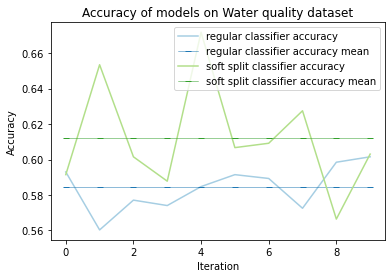

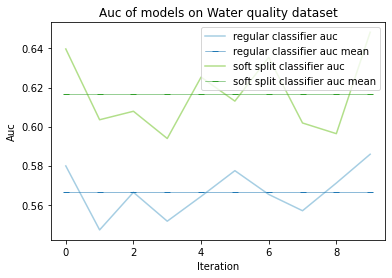

In [5]:
plotModelScore(scoresRegular, scoresSoftSplit,'Water Quality dataset','accuracy','test_accuracy')
plotModelScore(scoresRegular, scoresSoftSplit,'Water Quality dataset','auc','test_roc_auc')

Regarding the water quality dataset the soft split technique is slightly better then the default sklearn implementation, but still gives a better result on both the AUC and accuracy.
Its important to note  that the classes are imbalanced, in favor of the potable records, which might be a reasonable explanation for both classifications' poor results